## Imports
Import pandas, numpy, matplotlib, sklearn and seaborn.

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

In [283]:
customer_data = pd.read_csv('Mall_Customers.csv')

#Removing non-informative column CustomerID
customer_data.drop('CustomerID',axis=1,inplace=True)




In [284]:
customer_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [285]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
Gender                    200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.3+ KB


# Exploratory data analysis (EDA)

Analysing Categorical columns

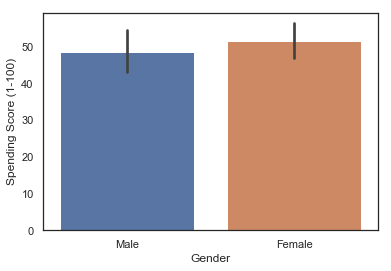

In [286]:
sns.barplot( y = customer_data['Spending Score (1-100)'], x = customer_data['Gender'])

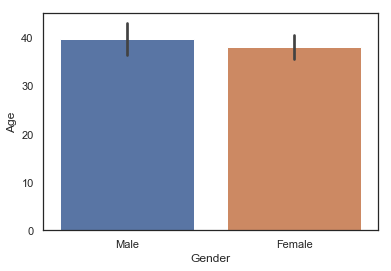

In [287]:
sns.barplot( y = customer_data['Age'], x = customer_data['Gender'])

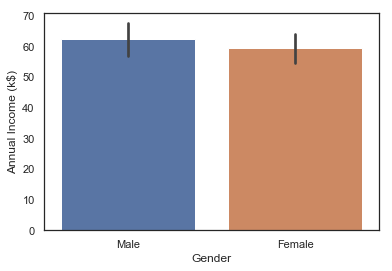

In [288]:
sns.barplot( y = customer_data['Annual Income (k$)'], x = customer_data['Gender'])

As it can be seen from the above 3 plots, the male-female values are in balance wrt all 0ther features

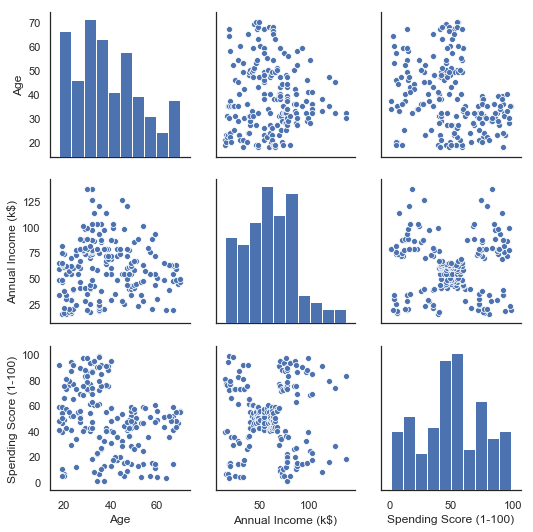

In [289]:
sns.pairplot(customer_data);


There is a pattern observed in the Annual Income vs Spending Score graph

In [290]:
#Factorizing Categorical column 'Gender'
customer_data['Gender']=pd.factorize(customer_data['Gender'])[0]

# Decomposing data to lower dimension for clustering

Visualizing high-dimensional data by projecting it into a low-dimensional space for easier visualization and grouping.

# 1. PCA (Principal Component Analysis)

PCA is fast, simple to use, and intuitive. Basically, PCA creates low-dimensional embeddings that best preserves the overall variance of the dataset. In PCA, linear projection is used (Similar to casting a shadow).

In [291]:
from sklearn.decomposition import PCA

In [298]:
pca = PCA(n_components=2)

In [299]:
customer_data_pca = pca.fit_transform(customer_data)
# customer_data_pca is a 2D array as we set the number of components of pca = 2

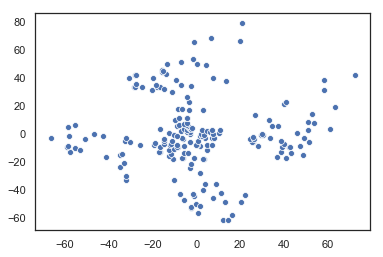

In [300]:
sns.scatterplot(customer_data_pca[:,0],customer_data_pca[:,1])

The above graph graph of PCA has caught the structure and relationship between Spending score and Annual income. Here data is homogeneous so we can't exactly specify certain number of clusters.

One drawback of PCA is that it is a linear projection, meaning it can’t capture non-linear dependencies. 

# 2. t-SNE (T-distributed Stochastic Neighbour Embedding)

It maps points in high dimensional space to a lower dimension so that the distances between the points remains almost the same. It can handle the crowding problem very well. The crowding problem basically comes from the curse of dimensionality. Another major benefit of t-SNE is that it uses “stochastic neighbors”. This means that there is no clear line between which points are neighbors of the other points. This lack of clear borders can be a major advantage because it allows t-SNE to naturally take both global and local structure into account. Local structure is more important than global structure, but points that are far away are not completely ignored, allowing for a “well-balanced” dimensionality reduction.

In [189]:
from sklearn.manifold import TSNE

In [190]:
tsne = TSNE(n_components=2)

In [191]:
customer_data_tsne = tsne.fit_transform(customer_data)

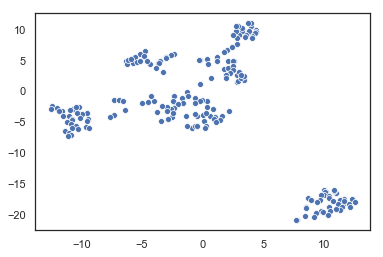

In [192]:
sns.scatterplot(customer_data_tsne[:,0],customer_data_tsne[:,1])

As can be seen, the seperation is better using TSNE as it accounts for non-linear relationships as well. Here we have atleast one distinctive cluster.

# Clustering of data

We don't know how many clusters should be used so we will use trial and error

The algorithm starts by treating each object as a singleton cluster. Next, pairs of clusters are successively merged until all clusters have been merged into one big cluster containing all objects. The result is a tree-based representation of the objects, named dendrogram.

See - https://www.youtube.com/watch?v=1jW9xlEtQao

In [210]:
from sklearn.cluster import AgglomerativeClustering as AggClustering

In [256]:
agg_clustering = AggClustering(n_clusters=6)

In [257]:
customer_cluster_assignment =  agg_clustering.fit_predict(customer_data)

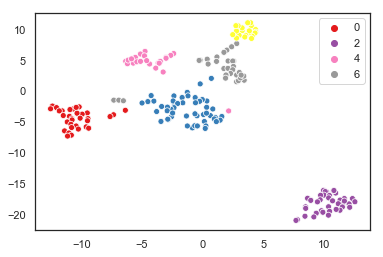

In [258]:
sns.scatterplot(x = customer_data_tsne[:,0], y = customer_data_tsne[:,1], hue = customer_cluster_assignment,  palette='Set1')

Constructing a dendogram

In [259]:
from scipy.cluster.hierarchy import dendrogram,ward

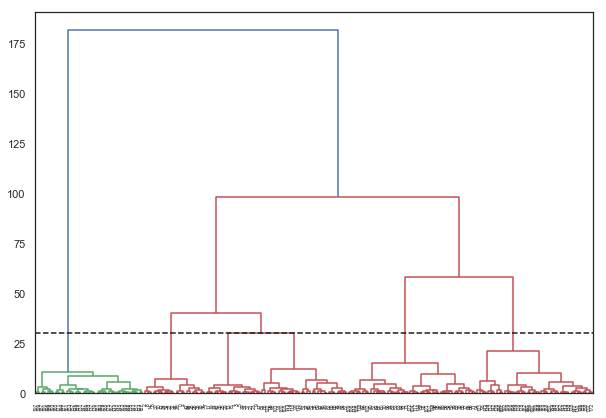

In [260]:
link = ward(customer_data_tsne)
sns.set(style='white')
plt.figure(figsize=(10,7))
dendrogram(link)
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [30,30],'--', c='k')
#ax.plot(bounds,'--', c='k')
plt.show()

The number of ideal clusters is 6

In [261]:
customer_data['predicted cluster'] = pd.DataFrame(customer_cluster_assignment)

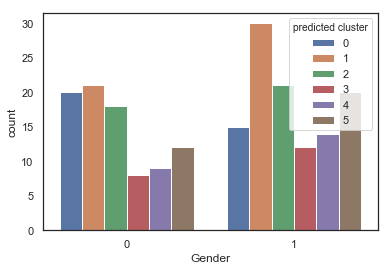

In [262]:
sns.countplot(customer_data['Gender'], hue = customer_data['predicted cluster'] )

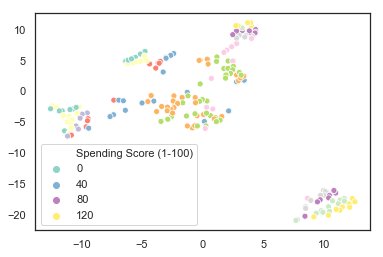

In [263]:
sns.scatterplot(x = customer_data_tsne[:,0], y= customer_data_tsne[:,1], hue = customer_data['Spending Score (1-100)'], palette='Set3')

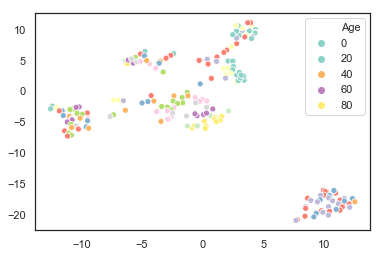

In [264]:
sns.scatterplot(x = customer_data_tsne[:,0], y= customer_data_tsne[:,1], hue = customer_data['Age'], palette='Set3')

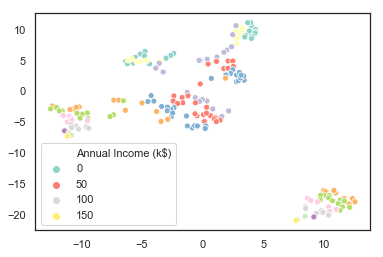

In [265]:
sns.scatterplot(x = customer_data_tsne[:,0], y= customer_data_tsne[:,1], hue = customer_data['Annual Income (k$)'], palette='Set3')

In [266]:
customer_data_clusters = pd.DataFrame()
customer_data_clusters['age median'] = customer_data['Age'].groupby(customer_data['predicted cluster']).median()
customer_data_clusters['spending score median'] = customer_data['Spending Score (1-100)'].groupby(customer_data['predicted cluster']).median()
customer_data_clusters['annual income median'] = customer_data['Annual Income (k$)'].groupby(customer_data['predicted cluster']).median()
customer_data_clusters.reset_index(inplace=True)

In [267]:
print(customer_data_clusters)

   predicted cluster  age median  spending score median  annual income median
0                  0          43                   16.0                  85.0
1                  1          50                   49.0                  54.0
2                  2          32                   83.0                  79.0
3                  3          23                   78.0                  23.5
4                  4          46                   17.0                  25.0
5                  5          24                   51.5                  55.5


# Silhouette Analysis

S.A. is a way to measure how close each point in a cluster is to the points in its neighboring clusters. Its a neat way to find out the optimum value for k during k-means clustering. Silhouette values lies in the range of [-1, 1]. A value of +1 indicates that the sample is far away from its neighboring cluster and very close to the cluster its assigned. Similarly, value of -1 indicates that the point is close to its neighboring cluster than to the cluster its assigned. And, a value of 0 means its at the boundary of the distance between the two cluster. Value of +1 is idea and -1 is least preferred. Hence, higher the value better is the cluster configuration.

In [268]:
from sklearn.metrics import silhouette_score

In [272]:
score = silhouette_score (customer_data, customer_data['predicted cluster'], metric='euclidean')

In [273]:
score

0.4455880042672558

S.A. Score is maximum when the number of clusters is 6